Let's explore our time series!

In [231]:
%matplotlib inline
from random import randint, seed
from fastdtw import fastdtw
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

sns.set(style='white')

In [232]:
data = pd.read_csv('data/train.txt', header=None, delim_whitespace=True)
print(data.shape)
data.head()

(45918, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


## Visualization

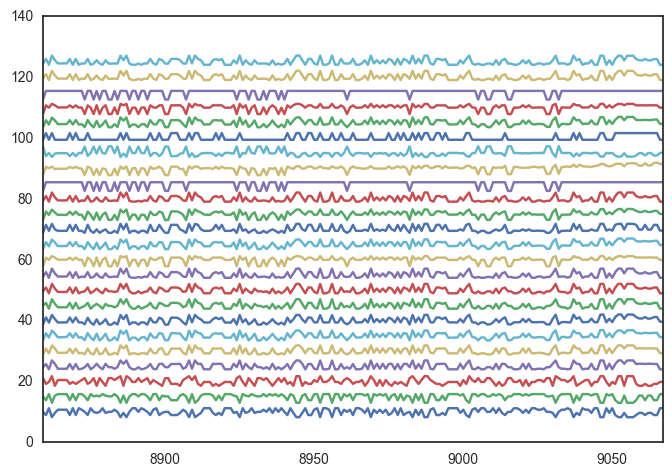

In [241]:
# sns.tsplot(data[data[0]<=3], unit=0, time=1, value=25, err_style='unit_traces') # not useful
# visualisation of all dimenstions of a randomly chosen serie
serie = data[data[0]==43]
serie_norm = (serie - serie.mean()) / serie.std()
for i in range(2, 26):
    (serie_norm[i]+5*i).plot(x=1)

In [127]:
# compute means accross all sensors and all time series
means = data.mean()
# remove first row (serie id) and ignore timestamp row
means = means.drop(labels=0, axis=0)
means[1] = 0
# compute standard deviations accross all sensors and all time series
stds = data.std()
# remove  first row (serie id) and ignore timestamp row
stds = stds.drop(labels=0, axis=0)
stds[1] = 1
# get list of series
grouped = data.groupby(0)
series = [group.drop(labels=0, axis=1) for name, group in grouped]

In [139]:
# renumber timestamps from the end of a serie
for serie in series:
    serie[1] = max(serie[1]) + 1 - serie[1]

# find the longes one
longest_serie = max([max(s[1]) for s in series])
# create new index
new_index = [i for i in range(longest_serie, 0, -1)]
# normalize the series, set index to timestamp and fill missing timestamps with NaNs
normalized_series = [((serie - means) / stds).set_index(1).reindex(new_index) for serie in series]

            0         1         2         3         4
1                                                    
357       NaN       NaN       NaN       NaN -0.270878
356       NaN       NaN       NaN       NaN  1.216650
355       NaN       NaN       NaN       NaN  1.216197
354       NaN       NaN       NaN       NaN  0.066969
353       NaN       NaN       NaN       NaN -0.271081
352       NaN       NaN       NaN       NaN  1.216088
351       NaN       NaN       NaN       NaN  1.216535
350       NaN       NaN       NaN       NaN -0.946430
349       NaN       NaN       NaN       NaN -0.946559
348       NaN       NaN       NaN       NaN  0.067503
347       NaN       NaN       NaN       NaN -0.270810
346       NaN       NaN       NaN       NaN -1.622827
345       NaN       NaN       NaN       NaN  0.743082
344       NaN       NaN       NaN       NaN -0.946579
343       NaN       NaN       NaN       NaN -0.271060
342       NaN       NaN       NaN       NaN  1.216575
341       NaN       NaN     

In [205]:
# list of all sensor readings
sensors = [None, None]
for i in range(2, 26):
    # dataframe for single sensor
    sensor = pd.DataFrame()
    for j in range(len(normalized_series)):
            serie = normalized_series[j]
            # column j+1 will contain readings of sensro i in j+1 serie
            sensor['s'+str(j+1)] = serie[i]
    sensors.append(sensor)

In [167]:
print(sensors[2])
#data = sensors[2].as_matrix().transpose()
#sns.tsplot(data=data)

           s1        s2        s3        s4        s5        s6        s7  \
1                                                                           
357       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
356       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
355       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
354       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
353       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
352       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
351       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
350       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
349       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
348       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
347       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

In [157]:
import numpy as np; np.random.seed(22)
import seaborn as sns; sns.set(color_codes=True)
x = np.linspace(0, 15, 31)
x
np.random.randn(10, 1)

array([[-0.09194992],
       [-1.46335065],
       [ 1.08179168],
       [-0.23932517],
       [-0.49112914],
       [-1.00227201],
       [ 0.9188215 ],
       [-1.1036321 ],
       [ 0.62649346],
       [-0.56151378]])

## Test set exploration

In [4]:
test_set = pd.read_csv('data/test.txt', header=None, delim_whitespace=True)
print(test_set.shape)
test_set.head()

(29820, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0016,0.0002,100.0,518.67,642.88,1587.21,1412.44,14.62,...,521.44,2388.10,8124.04,8.4363,0.03,393,2388,100.00,38.97,23.3029
1,1,2,24.9993,0.6215,80.0,462.54,536.45,1262.64,1055.44,7.05,...,164.32,2027.95,7865.20,10.8935,0.02,308,1915,84.93,14.29,8.6686
2,1,3,0.0004,0.0000,100.0,518.67,642.65,1589.75,1409.54,14.62,...,521.15,2388.19,8121.12,8.4620,0.03,393,2388,100.00,38.91,23.2693
3,1,4,10.0034,0.2500,20.0,489.05,604.44,1499.93,1315.34,10.52,...,371.42,2388.21,8123.53,8.6815,0.03,369,2319,100.00,28.60,17.0930
4,1,5,0.0024,0.0011,100.0,518.67,642.74,1585.47,1408.12,14.62,...,520.86,2388.13,8118.30,8.4617,0.03,392,2388,100.00,38.82,23.3124


In [5]:
test_set_desc = test_set[0].value_counts().describe()
test_set_desc

count    218.000000
mean     136.788991
std       59.707208
min       15.000000
25%       92.250000
50%      134.500000
75%      177.750000
max      364.000000
Name: 0, dtype: float64

In [6]:
data_desc = data[0].value_counts().describe()
data_desc

count    218.000000
mean     210.633028
std       43.595578
min      128.000000
25%      177.000000
50%      209.500000
75%      236.000000
max      357.000000
Name: 0, dtype: float64

In [7]:
data_desc - test_set_desc

count      0.000000
mean      73.844037
std      -16.111630
min      113.000000
25%       84.750000
50%       75.000000
75%       58.250000
max       -7.000000
Name: 0, dtype: float64

We have decieded to create the ground truth by trimming the time series in the train set by 20, 40,..., 120 steps.

## Ground truth creation

In [8]:
k = 6
seed(0)
ttl = [(randint(1, k) * 20) for _ in range(218)]
grouped = data.groupby(0)
train_set = [group.head(-ttl[name-1]).drop(labels=0, axis=1) for name, group in grouped]
n = len(train_set)
# train_set[:1]

## Extracting features from time series

In [9]:
features = pd.DataFrame([serie.describe().unstack() for serie in train_set], index=range(1,len(train_set)+1))
features.head()

1                                                          2   \
   count   mean        std  min    25%    50%     75%    max  count   
1  143.0   72.0  41.424630  1.0  36.50   72.0  107.50  143.0  143.0   
2   84.0   42.5  24.392622  1.0  21.75   42.5   63.25   84.0   84.0   
3  130.0   65.5  37.671829  1.0  33.25   65.5   97.75  130.0  130.0   
4   99.0   50.0  28.722813  1.0  25.50   50.0   74.50   99.0   99.0   
5  257.0  129.0  74.333707  1.0  65.00  129.0  193.00  257.0  257.0   

               ...          24            25                               \
        mean   ...         75%    max  count       mean       std     min   
1  24.023583   ...     28.5100  38.99  143.0  12.283824  6.005840  6.2461   
2  23.776865   ...     28.6600  39.19   84.0  12.526311  6.150168  6.2475   
3  24.141672   ...     28.4425  39.02  130.0  12.356802  5.965752  6.2467   
4  22.497542   ...     28.5800  39.06   99.0  12.659667  5.845426  6.2654   
5  24.142630   ...     28.5300  39.15  257.0  12.420558  5.674284  6.1718   

                                         
       25%      50%        75%      max  
1  8.44460  8.87980  17.109350  23.4194  
2  8.02045  8.96720  17.165175  23.4589  
3  6.42650  8.88905  17.031025  23.3181  
4  8.49000  8.96350  17.155350  23.4764  
5  8.49310  8.98040  17.095200  23.4700  

[5 rows x 200 columns]

## Computing distance matrix for feature vectors

In [10]:
# compute matrix of pairwise distances
euclidean_distances = pairwise_distances(features, metric='euclidean')
euclidean_distances.shape

(218, 218)

In [14]:
def dtw(x, y):
    dist, _ = fastdtw(x, y, dist=euclidean)
    return dist

# DTW is very slow so we precomputed the distances using
# dtw_distances = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         dtw_distances[i,j] = dtw(train_set[i], train_set[j])
# np.save('dtw_distances.npy', dtw_distances)

# and now we just load the precomputed distances to save the time
dtw_distances = np.load('dtw_distances.npy')
print(dtw_distances)
len(dtw_distances)

[[     0.          40898.32893813  39707.52834983 ...,  50359.48564805
   62102.43817827  40886.25259972]
 [ 40898.32893813      0.          39526.6005803  ...,  24974.63074217
   50083.2062372   26094.14232845]
 [ 39707.52834983  39526.6005803       0.         ...,  38493.90293035
   53826.71889442  36963.58725367]
 ..., 
 [ 50359.48564805  24974.63074217  38493.90293035 ...,      0.
   57514.65713313  27377.44587055]
 [ 62102.43817827  50083.2062372   53826.71889442 ...,  57514.65713313
       0.          50623.10726432]
 [ 40886.25259972  26094.14232845  36963.58725367 ...,  27377.44587055
   50623.10726432      0.        ]]


218

## Clustering: k-means

### K-means with Euclidian distances

In [15]:
y_pred_km_euc = KMeans(n_clusters=k).fit_predict(euclidean_distances)

In [18]:
# take a look at the result
tsne = TSNE(perplexity=20, learning_rate=1000, metric='precomputed')
emb = pd.DataFrame(tsne.fit_transform(euclidean_distances))
emb['y'] = y_pred_km_euc
emb['gt'] = ttl

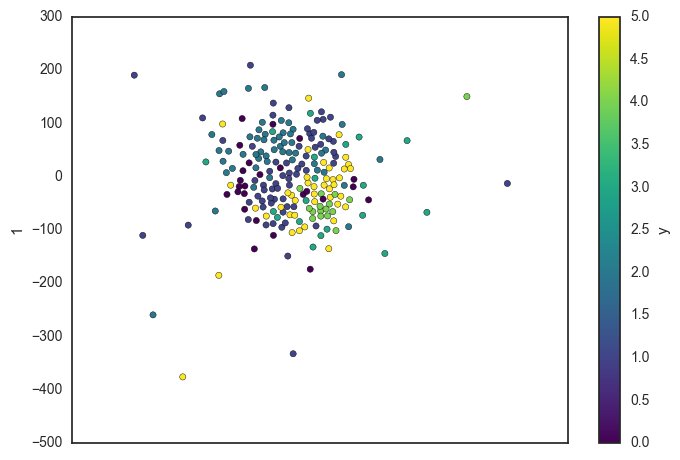

In [19]:
emb.plot(kind='scatter', x=0, y=1, c='y', cmap='viridis')

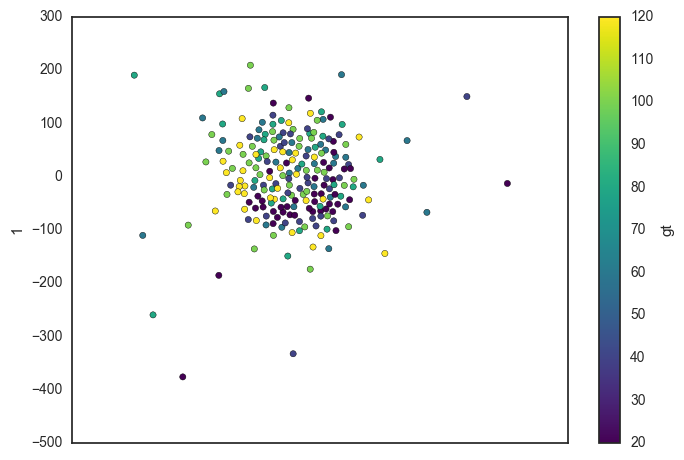

In [20]:
emb.plot(kind='scatter', x=0, y=1, c='gt', cmap='viridis')

### K-means with DTW

In [23]:
y_pred_km_dtw = KMeans(n_clusters=k).fit_predict(dtw_distances)

In [28]:
# take a look at the result
tsne = TSNE(perplexity=20, learning_rate=1000, metric='precomputed')
emb = pd.DataFrame(tsne.fit_transform(dtw_distances))
emb['y'] = y_pred_km_dtw
emb['gt'] = ttl

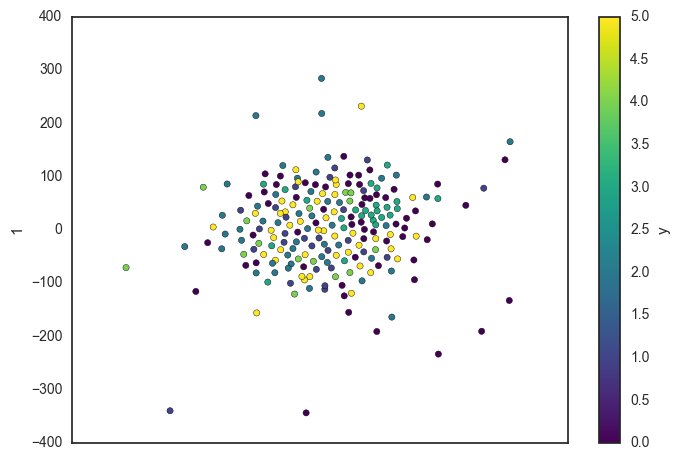

In [29]:
emb.plot(kind='scatter', x=0, y=1, c='y', cmap='viridis')

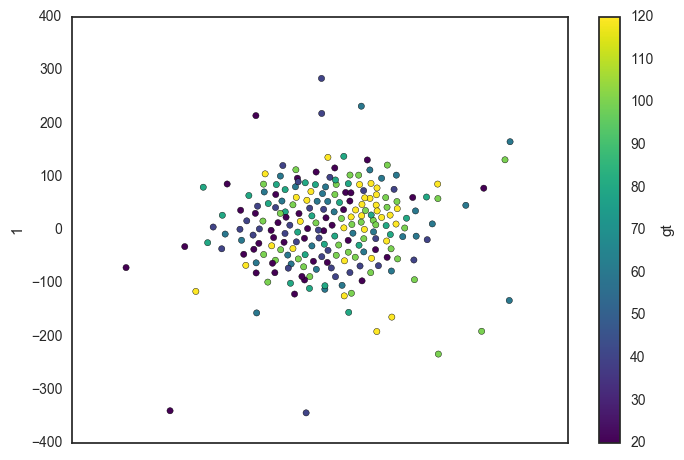

In [30]:
emb.plot(kind='scatter', x=0, y=1, c='gt', cmap='viridis')

## Clustering: Hierarchical agglomerative clustering

### HAC with Euclidian distances

In [31]:
y_pred_hac_euc = AgglomerativeClustering(n_clusters=k).fit_predict(euclidean_distances)

### HAC with DTW

In [32]:
y_pred_hac_dtw = AgglomerativeClustering(n_clusters=k).fit_predict(dtw_distances)

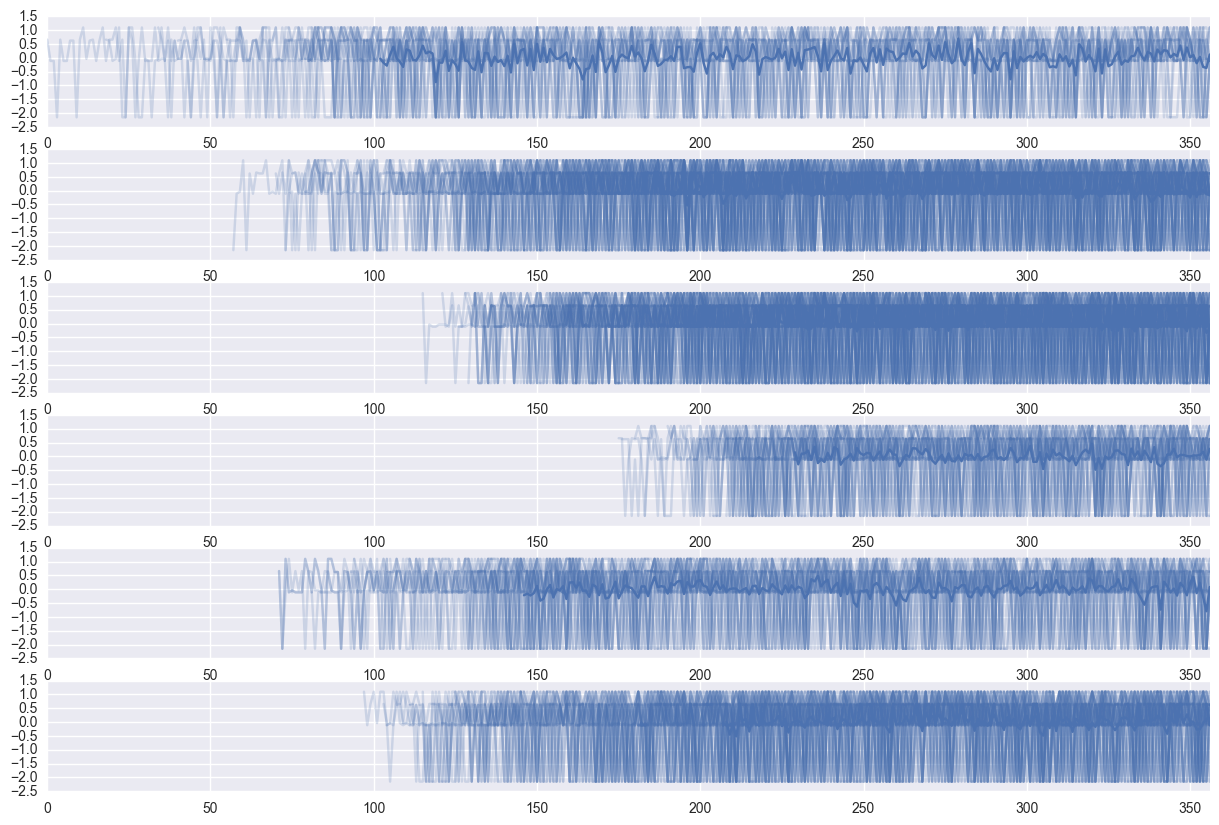

In [226]:
index_cluster_0 = y_pred_hac_dtw == 0
data = sensors[12].as_matrix().transpose()
data[index_cluster_0]
# sns.tsplot(data[data[0]<=3], unit=0, time=1, value=25, err_style='unit_traces') # not useful
#sns.tsplot(data=data[index_cluster_0], err_style='unit_traces')

num_cluster = len(set(y_pred_hac_dtw))

f, axis = plt.subplots(num_cluster, 1, figsize=(15, 10))
for c in range(num_cluster):
    index = y_pred_hac_dtw == c
    sns.tsplot(data=data[index], err_style='unit_traces', ax=axis[c])
    


## Clustering evaluation

### Mutual information

In [33]:
# K-means with Euclidean distances
ttl_pred = (y_pred_km_euc+1) * 20
normalized_mutual_info_score(ttl, ttl_pred)

0.1708125358711314

In [35]:
# K-means with DTW distances
ttl_pred = (y_pred_km_dtw+1) * 20
normalized_mutual_info_score(ttl, ttl_pred)

0.19491982430455335

In [36]:
# HAC with Euclidean distances
ttl_pred = (y_pred_hac_euc+1) * 20
normalized_mutual_info_score(ttl, ttl_pred)

0.16908412860146868

In [37]:
# HAC with DTW distances
ttl_pred = (y_pred_hac_dtw+1) * 20
normalized_mutual_info_score(ttl, ttl_pred)

0.19611889840135072

### Cluster Quality

We are not sure what exactly should cluster quality be. Instead we use Adjusted Rand Index as a second metric.

### Adjusted Rand Index

In [38]:
# K-means with Euclidean distances
ttl_pred = (y_pred_km_euc+1) * 20
adjusted_rand_score(ttl, ttl_pred)

0.065460694518778575

In [39]:
# K-means with DTW distances
ttl_pred = (y_pred_km_dtw+1) * 20
adjusted_rand_score(ttl, ttl_pred)

0.076759822721596926

In [40]:
# HAC with Euclidean distances
ttl_pred = (y_pred_hac_euc+1) * 20
adjusted_rand_score(ttl, ttl_pred)

0.06375107023503504

In [41]:
# HAC with DTW distances
ttl_pred = (y_pred_hac_dtw+1) * 20
adjusted_rand_score(ttl, ttl_pred)

0.079124192208908317